In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
print(X_footsteps_accelerations_absolute.shape)
print(Y_footsteps_accelerations_absolute.shape)

(17248, 31)
(17248, 4)


In [6]:
min(Y_footsteps_accelerations_absolute[:, 0])

-0.12590238451957703

In [7]:
max(Y_footsteps_accelerations_absolute[:, 0])

0.3487997502088547

# Multivariate Linear Regression (Foot prediction)

In [8]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [9]:
# Entries where FL is swinging
idxs = np.where(X_footsteps_accelerations_absolute[:, -2] == 1)[0]
X_footsteps_accelerations_absolute_FL_swinging = X_footsteps_accelerations_absolute[idxs]
Y_footsteps_accelerations_absolute_FL_swinging = Y_footsteps_accelerations_absolute[idxs]

In [10]:
len(idxs)

8638

In [11]:
X_footsteps_accelerations_absolute_FL_swinging[0, 34:37]

array([], dtype=float64)

In [12]:
Y_footsteps_accelerations_absolute[0]

array([ 0.03515556, -0.00011611,  0.03440189, -0.00369272])

## Predict FL foot -> x

### Linear Regression

In [13]:
def find_best_model(X, Y, runs=1000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [14]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_FL_swinging[:, 0:1], # previous motion command
               X_footsteps_accelerations_absolute_FL_swinging[:, 3:4], # current motion command
               X_footsteps_accelerations_absolute_FL_swinging[:, -5:-4], # previous CoM velocity
               X_footsteps_accelerations_absolute_FL_swinging[:, 10:12], # FL (x,y) position
               X_footsteps_accelerations_absolute_FL_swinging[:, 13:15], # FR (x,y) position
               X_footsteps_accelerations_absolute_FL_swinging[:, 16:18], # RL (x,y) position
               X_footsteps_accelerations_absolute_FL_swinging[:, 19:21])) # RR (x,y) position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_FL_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fl_relative_support_x = find_best_model(X, Y, runs=5000)

R2:  0.9970649186704662
RMSE:  0.005362084541968151
The lowest error is:  5.171126301883877e-07
The highest error is:  0.01884626490333907
The avg. error is:  0.003920595976510927


In [15]:
model_fl_relative_support_x.coef_

array([[ 0.00545434,  0.01739161,  0.18522134, -0.89071786,  0.09016279,
        -0.18906143, -0.02083055,  0.0213749 ,  0.13312945, -0.01031446,
        -0.21463468]])

In [16]:
model_fl_relative_support_x.intercept_

array([0.20550511])

In [43]:
inp = [0.9,0,0,0.9,0,0,0.96, -0.04, -0.03, -0.02, 0.37, 0.13, 0.09, -0.12, -0.4,0.12, -0.11,-0.12]

Text(0, 0.5, 'Predictions')

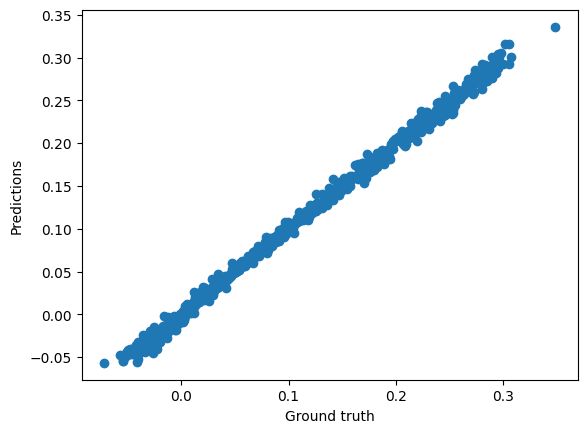

In [17]:
# The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [19]:
#for idx, prediction in enumerate(predictions):
#    print(f'{X_test[idx, 0]} -> {X_test[idx, 3]}. CoM: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}.')

### Predict FL foot -> y

In [20]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_FL_swinging[:, 0:1], # previous motion command
               X_footsteps_accelerations_absolute_FL_swinging[:, 3:4], # current motion command
               X_footsteps_accelerations_absolute_FL_swinging[:, -5:-4], # previous CoM velocity
               X_footsteps_accelerations_absolute_FL_swinging[:, 10:12], # FL (x,y) position
               X_footsteps_accelerations_absolute_FL_swinging[:, 13:15], # FR (x,y) position
               X_footsteps_accelerations_absolute_FL_swinging[:, 16:18], # RL (x,y) position
               X_footsteps_accelerations_absolute_FL_swinging[:, 19:21])) # RR (x,y) position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_FL_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fl_relative_support_y = find_best_model(X, Y, runs=5000)

R2:  0.9610932168901425
RMSE:  0.005037349340332984
The lowest error is:  5.656958228419939e-06
The highest error is:  0.022385778740815064
The avg. error is:  0.0034876886476517075


In [21]:
model_fl_relative_support_y.coef_

array([[ 0.0013023 , -0.00506666,  0.01902463,  0.13790978, -1.26919181,
         0.34816261,  0.39403043, -0.40229086,  0.07602582, -0.13693963,
        -0.01841431]])

In [22]:
model_fl_relative_support_y.intercept_

array([-0.05411656])

Text(0, 0.5, 'Predictions')

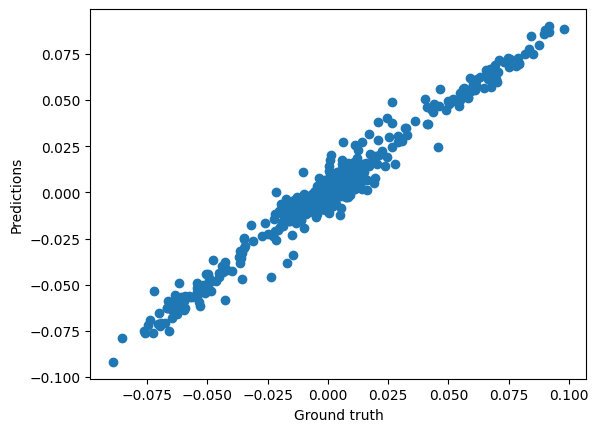

In [23]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [43]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')